# Пример классификации с помощью простой нейронной сети в PyTorch

Создадим нейронную сеть вида:

$$
f(X) := \sigma ((X A_1^\top + b_1)) A_2^\top + b_2
$$
, где $\sigma$ функция активации ReLU, $A_1 \in \mathbb{R}^{784 \times 128}$ и $A_2 \in \mathbb{R}^{\text{128} \times 784}$.

В качестве лосс-функции используется функция кросс-энтропии.

In [10]:
import numpy as np
from sklearn.datasets import fetch_openml
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
def load_mnist(n_images):
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)

    X = mnist.data.astype('float32') / 255.0
    y = mnist.target.astype('int64')

    rng = np.random.default_rng(seed=42)
    indices = rng.permutation(n_images)
    X, y = X[indices], y[indices]

    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    return X_train, y_train, X_test, y_test


def relu(x):
    return torch.clamp(x, min=0.0)


def compute_loss(f, X, y):
    criterion = torch.nn.CrossEntropyLoss()
    return criterion(f(X), y)


def generate_target_f(A1, b1, A2, b2):
    def f(X):
        hidden = relu(X @ A1.T + b1)    # (batch, 128)
        out = hidden @ A2.T + b2        # (batch, 10)
        return out                      # logits for 10 classes
    return f

In [12]:
n_images = 100
X_train, y_train, X_test, y_test = load_mnist(n_images)

# Convert to torch tensors
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

In [13]:
X_train = X_train.view(-1, 784)
X_test = X_test.view(-1, 784)

In [ ]:
steps = 5000

A1 = torch.randn((128, 784), dtype=torch.float32, requires_grad=True)
A2 = torch.randn((10, 128), dtype=torch.float32, requires_grad=True)
b1 = torch.randn((128,), dtype=torch.float32, requires_grad=True)
b2 = torch.randn((10,), dtype=torch.float32, requires_grad=True)

# generate_target_f(X_train, y_train, X_test, y_test)
simple_nn = generate_target_f(A1, b1, A2, b2)

train_loss_history = []
test_loss_history = []
test_acc_history = []

for i in range(steps):
    loss = compute_loss(simple_nn, X_train, y_train) # forward pass
    train_loss_history.append(loss)
    if i % 100 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")
        with torch.no_grad():
            test_loss = compute_loss(simple_nn, X_test, y_test)
            test_loss_history.append(test_loss)
            pred_test = torch.argmax(simple_nn(X_test), dim=1)
            test_acc = (pred_test == y_test).float().mean()
            test_acc_history.append(test_acc)
            print(f"Test Loss: {test_loss.item():.4f}, Test Acc: {test_acc.item():.4f}")
    loss.backward() # backward pass

    with torch.no_grad():
        A1 -= 0.001 * A1.grad
        b1 -= 0.001 * b1.grad
        A2 -= 0.001 * A2.grad
        b2 -= 0.001 * b2.grad

        A1.grad.zero_()
        b1.grad.zero_()
        A2.grad.zero_()
        b2.grad.zero_()

Iteration 0, Loss: 99.3751449584961
Test Loss: 102.8091, Test Acc: 0.0000
Iteration 100, Loss: 48.798500061035156
Test Loss: 73.4434, Test Acc: 0.0500
Iteration 200, Loss: 28.317821502685547
Test Loss: 58.4990, Test Acc: 0.2000
Iteration 300, Loss: 17.450927734375
Test Loss: 52.9504, Test Acc: 0.2000
Iteration 400, Loss: 11.092219352722168
Test Loss: 49.0796, Test Acc: 0.2500
Iteration 500, Loss: 7.317131996154785
Test Loss: 46.5385, Test Acc: 0.2500
Iteration 600, Loss: 5.098341941833496
Test Loss: 44.6794, Test Acc: 0.2500
Iteration 700, Loss: 3.540001630783081
Test Loss: 43.4098, Test Acc: 0.2500
Iteration 800, Loss: 2.3470990657806396
Test Loss: 42.4472, Test Acc: 0.3000
Iteration 900, Loss: 1.380844235420227
Test Loss: 42.2565, Test Acc: 0.3500
Iteration 1000, Loss: 0.7605313062667847
Test Loss: 42.4336, Test Acc: 0.3000
Iteration 1100, Loss: 0.37467247247695923
Test Loss: 42.3487, Test Acc: 0.3000
Iteration 1200, Loss: 0.2098059356212616
Test Loss: 41.9015, Test Acc: 0.3500
Itera

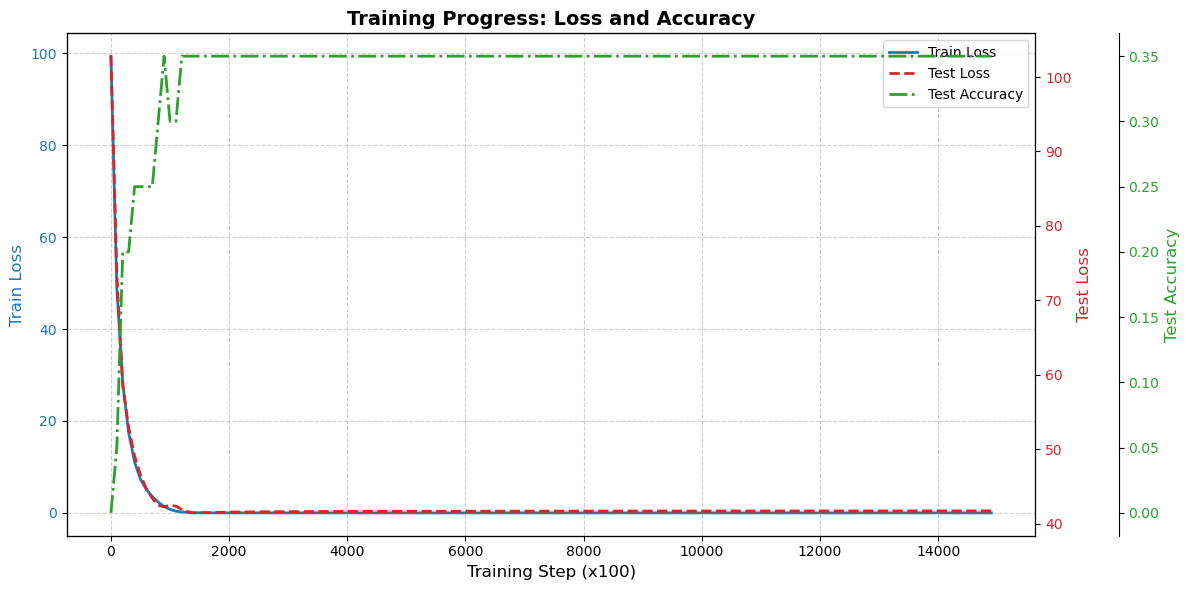

In [15]:
import matplotlib.pyplot as plt

# Convert histories to numpy arrays or lists of floats for plotting
train_loss_vals = [l.item() for l in train_loss_history]
test_loss_vals = [l.item() for l in test_loss_history]
test_acc_vals = [a.item() for a in test_acc_history]

# Create figure and first axis (train loss)
fig, ax1 = plt.subplots(figsize=(12, 6))

# === First axis: Train Loss (left y-axis) ===
color1 = 'tab:blue'
ax1.set_xlabel('Training Step (x100)', fontsize=12)
ax1.set_ylabel('Train Loss', color=color1, fontsize=12)
ax1.plot(range(0, steps, 100), train_loss_vals[::100], color=color1, label='Train Loss', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, linestyle='--', alpha=0.6)

# === Second axis: Test Loss (right y-axis #1) ===
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Test Loss', color=color2, fontsize=12)
ax2.plot(range(0, steps, 100), test_loss_vals, color=color2, label='Test Loss', linestyle='--', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color2)

# === Third axis: Test Accuracy (right y-axis #2, slightly offset) ===
ax3 = ax1.twinx()
# Offset the third axis to avoid overlapping with second
ax3.spines['right'].set_position(('outward', 60))  # Push it outward
color3 = 'tab:green'
ax3.set_ylabel('Test Accuracy', color=color3, fontsize=12)
ax3.plot(range(0, steps, 100), test_acc_vals, color=color3, label='Test Accuracy', linestyle='-.', linewidth=2)
ax3.tick_params(axis='y', labelcolor=color3)

# === Titles and legends ===
plt.title('Training Progress: Loss and Accuracy', fontsize=14, fontweight='bold')

# Create combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper right')

fig.tight_layout()  # Prevent label cutoff
plt.show()